In [1]:
# Read in transit data,
# and try to fit with Optim() + LMProblem() fitter from https://github.com/langfzac/nbody_fits

# We'll exclude the periodic prior in the fit.
# I am going to start from random parameters.
# We iterate with BFGS, Newton & L-M, using 10 iterations with a limit of
# 25 steps each.

using NbodyGradient, DelimitedFiles, LevenburgMarquardt, Statistics, PyPlot, ForwardDiff, SpecialFunctions, LinearAlgebra, Optim, LineSearches


In [2]:
# Use CGS units
# (The paths need updating from the TRAPPIST1_Spitzer repository)

include("/Users/ericagol/Software/TRAPPIST1_Spitzer/src/CGS.jl")
using Main.CGS# Add in Student's-t log probability function

# Include scripts for computing student's-t probability & linear regression:
include("/Users/ericagol/Software/TRAPPIST1_Spitzer/src/v09_eps0.1_2k/log_students_prob.jl")
include("/Users/ericagol/Software/TRAPPIST1_Spitzer/src/regress.jl")

# Add in script for optimizing TTV fits taken from github.com/langfzac/nbody_fits:
# (The path needs to be updated)
include("/Users/ericagol/Software/nbody_fits/scripts/periodic_scripts_student_optim_method.jl")

find_ephem (generic function with 1 method)

In [12]:
# Read in the transit time from Agol et al. (2021), plus new
# times for planets b-h from Elsa :
#data_SPEC = readdlm("TOI-2015.01_TTVs_measurements_P_fixed_modify.res",',',comments=true,comment_char='#')

data_SPEC = readdlm("TOI2015_all_data_08042023.txt",comments=true,comment_char='#')

nobs = size(data_SPEC)[1]

# Create data array for match_transit routine:
data = zeros(nobs,4)

# Only one transiting planet:
data[:,1] .= 1.0

# Number of transits:
data[:,2] .= round.((data_SPEC[:,1] .- t01 .- 2450000.0)/p1)

# Transit time & uncertainty:
data[:,3:4] .= data_SPEC[:,1:2]

# Subtract off a reference time to (hopefully) make the derivatives more accurate:
tref = 2458955.0
data[:,3] .-= tref

# Set up some initial parameters: starting time of integrration (t0)
# time step (h), and number of planets:
t0 = 2458955.0; h = 0.15; nplanet = 2;

t0 -= tref

0.0

In [15]:
# Load in the best parameters from a prior fit:
using JLD2
@load "TOI2015_v13_5-3_chisquare_09182023.jld" pbest_noprior
pbest_chi = pbest_noprior

# Set the host star to one solar mass:
mstar = 1.0

1-element Vector{Symbol}:
 :pbest_noprior

In [18]:
println("Masses: ",pbest_chi[1].*(mstar*MSUN/MEARTH)," M_e ",pbest_chi[2].*(mstar*MSUN/MEARTH)," M_e")
println("Periods: ",pbest_chi[3]," d, ",pbest_noprior[4]," d")
println("Eccentricities: ",sqrt(pbest_chi[9]^2+pbest_chi[7]^2)," ",sqrt(pbest_chi[10]^2+pbest_chi[8]^2))

Masses: 7.910925858964606 M_e 14.332261332241966 M_e
Periods: 3.3446195164535464 d, 5.588277065507592 d
Eccentricities: 0.04502484453114387 0.06381298116596369


In [20]:
# Read in the transit times from Barkaoui (8/4/2023) & Jones et al. (arXiv:2310.11775):
#data_SPEC = readdlm("TOI-2015.01_TTVs_measurements_P_fixed_modify.res",',',comments=true,comment_char='#')
data_SPEC = readdlm("TOI2015_all_data_08042023.txt",comments=true,comment_char='#')

# Sort this array in order of the transit times:
data_SPEC = sortslices(data_SPEC,dims=1)


nobs = size(data_SPEC)[1]

transp = [27,0]
# Create data array for match_transit routine:
data = zeros(nobs,4)
# Only one planet:
data[:,1] .= 1.0
# Number of transits:
data[:,2] .= round.((data_SPEC[:,1] .- t01 .- 2450000.0)/p1)
# Transit time & uncertainty:
data[:,3:4] .= data_SPEC[:,1:2]

# Subtract off a reference time to (hopefully) make the derivatives more accurate:
tref = 2458955.0
data[:,3] .-= tref

# Set up some initial parameters: starting time of integrration (t0)
# time step (h), and number of planets:
t0 = 2458955.0; h = 0.15; nplanet = 2;

t0 -= tref

# Now, guess some initial orbital elements (not using
# this right now).  First, set up elements array:
elements=zeros(nplanet+1,7); 
# Set stellar mass to unity:
elements[1,1] = 1.0; 

elements[2:nplanet+1,1:5] .= reshape(pbest_chi[1:5*nplanet],nplanet,5)
# Inclination:
elements[1:nplanet+1,6] .= 0.5*pi
# Longitude of nodes:
elements[1:nplanet+1,7] .= pi

3-element view(::Matrix{Float64}, 1:3, 7) with eltype Float64:
 3.141592653589793
 3.141592653589793
 3.141592653589793

1.0383444067340828 3.348784435909821 [3.3446195164535464, 1.035296209183558]


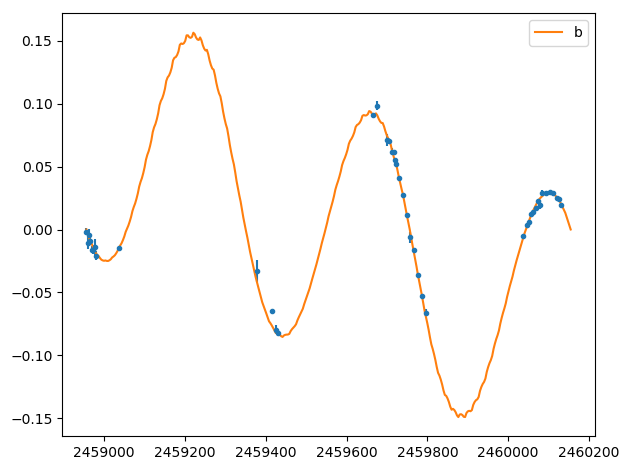

In [21]:
# Total number of transits:
#ntrans = sum(ntransp)
ntrans = nobs

# Create initial conditions structure:
ic = ElementsIC(t0, nplanet+1, elements);

# Set up integrator:
intr = Integrator(h, 0.0, 1200.0);

# Initialize state:
s = State(ic);

# Allocate the transit-timing structure:
tt = TransitTiming(intr.tmax,ic);

# Carry out computation of transit times:
intr(s,tt,grad=false)

# Match the transits up:
tmod,ip,jp = match_transits(data,ic.elements,tt.tt,tt.count);

pygui(false)
#fig,axes = subplots(1,1); 
pname = ["b","c","d","e","f","g","h"]
iplot = [1,1,2,3,3,4,4]; offset =[0,0,1,1,1,1,1]
#for iip=1:1
  #ax = axes[iplot[iip]]
  iip = 1
  jjp = data[:,1] .== iip
  #println(ic.elements[iip+1,2:3])
  nt = tt.count[iip+1]
  ttall = tt.tt[iip+1,1:nt] ; indx = collect(0:nt-1)
  pp = mean(ttall[2:end] .- ttall[1:end-1])
  t0p = mean(ttall .- pp .* indx)
  println(t0p," ",pp," ",ic.elements[iip+1,2:3])
  errorbar(data[jjp,3] .+ tref,data[jjp,3] .- ic.elements[iip+1,3] .- pp .*
        (round.(Int64,(data[jjp,3] .- t0p)./pp)),data[jjp,4],fmt=".")
  #jout = (data[:,1] .== iip) .& (abs.((data[:,3] .- tmod_noprior)./data[:,4]) .> 3.0)
  #println(iip," ",sum(jout)," ",sum(jjp)," ",sum(jout)/sum(jjp)," ",sum(resid_noprior[jjp].^2)," ",sum(resid_noprior[jout].^2)," ",sum(jjp)-5," ",sum(resid_noprior[jjp].^2)/(sum(jjp)-5))
  #errorbar(data[jout,3] .+ tref,data[jout,3] .- ic.elements[iip+1,3] .- pp .*
  #      (round.(Int64,(data[jout,3] .- t0p)./pp)),data[jout,4],fmt="o")
  plot(ttall .+ tref,ttall .- ic.elements[iip+1,3] .- pp .* indx,label=pname[iip])
  legend()
  #for ic = 1:ntrans
  #  if data[ic,1] == iip && (abs((data[ic,3] .- tmod[ic])./data[ic,4]) > 5.0)
  #    println(data[ic,1]," ",data[ic,2]," ",data[ic,3] .+ tref," ",data[ic,4],",",
  #          tmod[ic]+tref,",",abs((data[ic,3] .- tmod[ic])./data[ic,4]))
  #  end
  #end
#end
tight_layout()

In [22]:
pbest_noprior = deepcopy(pbest_chi)

10-element Vector{Float64}:
  7.072133977387458e-5
  0.00012812618162219883
  3.3446195164535464
  5.588277065507592
  1.035296209183558
  4.717322512264886
  0.034474743542576965
 -0.01922963971127812
  0.028960812880981502
  0.06084667223326246

In [23]:
ic.elements[2:nplanet+1,1:5] .= reshape(pbest_noprior[1:5*nplanet],nplanet,5)

# Okay, now let's try to optimize the fit.  We will
# try a few different methods.  This case started from the fit to Barkaoui data from 8/4/2023.
# We've transformed the mass, t0 & eccentricity variables, which
# seems to give much better convergence!

# Set up parameters for periodic constraint (used below):
# alpha is no longer used; nphase is number of phases to compare periodic constraint;
# nperiod is the multiple of per0 = 36.15 to use (for TRAPPIST-1):
alpha = 0.986; nphase=11; nperiod=3; 

# Reference every planet to rotating frame of planet b...
iref=ones(Int64,nplanet); 
# ...except for planet b which we will reference to planet c:
iref[1]=2

# Now, let all parameters vary.  Select which parameters to vary:
#fixpar = zeros(Bool,5*nplanet+3)  # Every parameter allowed to vary...
#fixpar = zeros(Bool,5*nplanet+2)  # Every parameter allowed to vary...
fixpar = zeros(Bool,5*nplanet)  # Every parameter allowed to vary...

# Optimize:
F_noprior_save = Inf; F_noprior = 0.0; G_noprior = 0.0; H_noprior=0.0; telapse_noprior = 0.0; dchi_noprior=0.0
ftol = 1e-5; iter = 0; itmax = 20
while abs(F_noprior_save - F_noprior) > ftol && iter < itmax
  F_noprior_save = F_noprior
  pbest_noprior,F_noprior,G_noprior,H_noprior,telapse_noprior,dchi_noprior = 
    optimize_ttv_periodic_student_lmagol(data,ic,tt,nplanet,alpha,iref,nperiod,nphase,fixpar;
    tmax_ttv=1200.0,verbose=true,comp_student=false,itmax=10,tol=1e-8,method=repeat(["BFGS","Newton","LM"],10),use_prior=false);
  ic.elements[2:nplanet+1,1:5] .= reshape(pbest_noprior[1:5*nplanet],nplanet,5)
  println(iter," ",pbest_noprior[1:5*nplanet])
  iter += 1
end

Iter     Function value   Gradient norm 
     0     1.747756e+02     2.832731e+06
 * time: 0.021179914474487305
     1     1.745364e+02     1.949361e+06
 * time: 1.7190608978271484
     2     1.741698e+02     1.618647e+06
 * time: 2.513429880142212
     3     1.720201e+02     1.690601e+06
 * time: 3.2899410724639893
     4     1.715264e+02     1.669249e+06
 * time: 4.066035985946655
     5     1.709181e+02     1.734167e+06
 * time: 4.838147878646851
     6     1.702470e+02     1.743893e+06
 * time: 6.39625096321106
     7     1.695952e+02     1.578603e+06
 * time: 8.740782976150513
     8     1.687702e+02     4.394900e+05
 * time: 10.30059289932251
     9     1.662908e+02     2.231964e+06
 * time: 10.819035053253174
    10     1.662068e+02     1.751628e+06
 * time: 11.332032918930054
fit.minimum: 166.20680560068922 Fbest: Inf diff: -Inf
Iter     Function value   Gradient norm 
     0     1.662068e+02     1.751628e+06
 * time: 0.00010609626770019531
     1     1.660455e+02     3.105040e

     2     1.607790e+02     1.085952e-01
 * time: 2.119915008544922
     3     1.607790e+02     8.036292e-02
 * time: 2.65021014213562
     4     1.607790e+02     9.638663e-02
 * time: 3.1883630752563477
     5     1.607790e+02     2.394000e-01
 * time: 3.717961072921753
     6     1.607790e+02     1.659002e+00
 * time: 4.241948127746582
     7     1.607790e+02     8.669109e+00
 * time: 4.768533229827881
     8     1.607790e+02     2.838360e+00
 * time: 5.3320090770721436
     9     1.607790e+02     2.164789e+01
 * time: 6.361386060714722
    10     1.607790e+02     1.932986e+01
 * time: 7.1479880809783936
fit.minimum: 160.77897301915596 Fbest: 160.77897301078536 diff: 8.370591331186006e-9
Iter     Function value   Gradient norm 
     0     1.607790e+02     1.932986e+01
 * time: 5.698204040527344e-5
     1     1.607790e+02     1.778237e+00
 * time: 0.7908890247344971
     2     1.607790e+02     4.755367e+00
 * time: 1.8476600646972656
     3     1.607790e+02     1.137779e+00
 * time: 2

     4     1.607790e+02     4.694465e-03
 * time: 1.9389550685882568
     5     1.607790e+02     1.579827e-01
 * time: 2.420753002166748
     6     1.607790e+02     1.873553e-01
 * time: 2.903272867202759
     7     1.607790e+02     8.929839e-02
 * time: 3.387259006500244
     8     1.607790e+02     5.703471e-01
 * time: 3.8768529891967773
     9     1.607790e+02     1.349817e+00
 * time: 4.601644039154053
    10     1.607790e+02     1.211614e+00
 * time: 5.329068899154663
fit.minimum: 160.77897301960863 Fbest: 160.77897300368468 diff: 1.5923944829410175e-8
Iter     Function value   Gradient norm 
     0     1.607790e+02     1.211614e+00
 * time: 6.103515625e-5
     1     1.607790e+02     1.728437e-01
 * time: 0.9723830223083496
     2     1.607790e+02     1.162760e+00
 * time: 2.183361053466797
     3     1.607790e+02     4.702452e-02
 * time: 3.1533188819885254
     4     1.607790e+02     4.357133e-01
 * time: 4.359298944473267
     5     1.607790e+02     1.416809e-01
 * time: 5.3166

     9     1.607790e+02     1.315468e-01
 * time: 8.922295093536377
    10     1.607790e+02     2.045752e-01
 * time: 9.89503002166748
fit.minimum: 160.77897301859102 Fbest: 160.77897301472782 diff: 3.863192432618234e-9
Best params: [69.59813532496253, 134.2873543389364, 3.3443303957348403, 5.5883095045099065, 1.0369676554539384, 4.693689423040816, 43.37693961350409, -13.924538897959486, -11.857325590993497, 26.566352027826085] nll: 160.77897300778582 Elapsed time: 8.617125988006592
Iter     Function value   Gradient norm 
     0     1.607790e+02     3.486009e-02
 * time: 9.894371032714844e-5
     1     1.607790e+02     2.756067e-02
 * time: 0.4868190288543701
     2     1.607790e+02     2.597256e-01
 * time: 0.9691178798675537
     3     1.607790e+02     1.601384e-01
 * time: 1.4554588794708252
     4     1.607790e+02     1.888387e-01
 * time: 1.941572904586792
     5     1.607790e+02     2.993932e-01
 * time: 2.4273250102996826
     6     1.607790e+02     4.105362e-01
 * time: 2.9180

fit.minimum: 160.77897301259816 Fbest: 160.77897301862106 diff: -6.022901288815774e-9
Best params: [69.59812766594445, 134.28735244268145, 3.344330395339205, 5.588309504117121, 1.0369676557623297, 4.6936894784400005, 43.37694793639068, -13.924528070063324, -11.857416517098265, 26.566288942163407] nll: 160.77897300848093 Elapsed time: 4.476460933685303
Iter     Function value   Gradient norm 
     0     1.607790e+02     5.375119e-01
 * time: 9.799003601074219e-5
     1     1.607790e+02     8.064084e-02
 * time: 0.48090100288391113
     2     1.607790e+02     3.149906e-02
 * time: 1.199828863143921
     3     1.607790e+02     6.130241e-02
 * time: 1.6746280193328857
     4     1.607790e+02     6.238653e-02
 * time: 2.1587040424346924
     5     1.607790e+02     2.136073e-01
 * time: 2.6360528469085693
     6     1.607790e+02     2.334290e-01
 * time: 3.136038064956665
     7     1.607790e+02     1.125895e-01
 * time: 3.6323750019073486
     8     1.607790e+02     1.838074e-01
 * time: 4.

In [24]:
pbest_noprior

10-element Vector{Float64}:
  6.95981258350793e-5
  0.0001342873539158128
  3.344330395214178
  5.588309503999432
  1.0369676556674814
  4.693689489415038
  0.04337695071508257
 -0.013924524796786452
 -0.01185744485193034
  0.026566268360560107

In [25]:
F_noprior - F_noprior_save

1.65391611517407e-9

In [26]:
ic_chi = deepcopy(ic)
ic_chi.elements[2:nplanet+1,1:5] .= reshape(pbest_noprior[1:5*nplanet],nplanet,5)
ic_chi = ElementsIC(t0,nplanet+1,ic_chi.elements)
tt_chi = TransitTiming(intr.tmax,ic_chi)
s = State(ic_chi)
intr(s,tt_chi,grad=false)
tmod_chi,ip,jp = match_transits(data,ic_chi.elements,tt_chi.tt,tt_chi.count);

In [27]:
ic_chi.elements

3×7 Matrix{Float64}:
 1.0          0.0      0.0       0.0         0.0        1.5708  3.14159
 6.95981e-5   3.34433  1.03697   0.043377   -0.0118574  1.5708  3.14159
 0.000134287  5.58831  4.69369  -0.0139245   0.0265663  1.5708  3.14159

1.0393199192716482 3.348781365637034 [3.344330395214178, 1.0369676556674814]
[0.0041209914325814395, 4.457554941006568e-5, 0.10417997180893093, 156.21617113833346, 441.0862561696355, -0.0012379421438942634, 71.88574601960552, 323.68240207838534]
1.0 137.0 2.4594147537e6 0.0013,2.4594147441717763e6,7.329402459128268


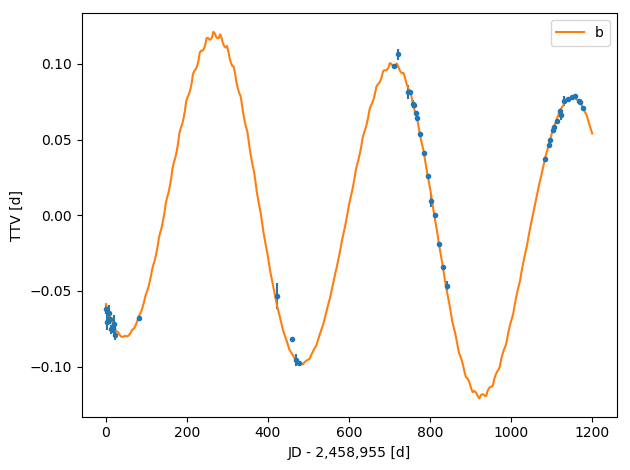

In [47]:
pygui(false)
#fig,axes = subplots(1,1); 
pname = ["b","c","d","e","f","g","h"]
iplot = [1,1,2,3,3,4,4]; offset =[0,0,1,1,1,1,1]
iip = 1
jjp = data[:,1] .== iip
nt = tt_chi.count[iip+1]
ttall = tt_chi.tt[iip+1,1:nt] ; indx = collect(0:nt-1)
pp = mean(ttall[2:end] .- ttall[1:end-1])
t0p = mean(ttall .- pp .* indx)
println(t0p," ",pp," ",ic_chi.elements[iip+1,2:3])
# Do a better job removing TTVs:
ntall = length(ttall)
fn = zeros(2,ntall); fn[1,:] .= 1.0; fn[2,:] .= round.(Int64,(ttall .- t0p)./pp)
coeff_ttv,cov_ttv = regress(fn,ttall,ones(ntall))
#errorbar(data[jjp,3],data[jjp,3] .- ic_chi.elements[iip+1,3] .- pp .*
#        (round.(Int64,(data[jjp,3] .- t0p)./pp)),data[jjp,4],fmt=".")
errorbar(data[jjp,3],data[jjp,3] .- coeff_ttv[1] .- coeff_ttv[2] .*
        (round.(Int64,(data[jjp,3] .- coeff_ttv[1])./coeff_ttv[2])),data[jjp,4],fmt=".")
#ttvall = ttall .- ic_chi.elements[iip+1,3] .- pp .* indx
ttvall = ttall .- coeff_ttv[1] .- coeff_ttv[2] .* fn[2,:]
plot(ttall ,ttvall,label=pname[iip])
#plot(ttall, 0.065 .- (ttall .- 500.0)*4.5e-5 .+ 0.105 .* sin.((ttall .- 156.0)*2pi/445.0))

function sin_fit(x)
   sin_mod = x[1] .- (ttall .- 500.0).*x[2] .+ x[3] .* sin.((ttall .- x[4]).*2pi/x[5]) .+ x[6] .* sin.((ttall .- x[7]).*2pi/x[8])
   return sum((ttvall .- sin_mod).^2)
end


result = optimize(sin_fit,[0.065,4.5e-5,0.105,156.0,445.0,0.005,75.0,225.0])
println(result.minimizer)
x0 = result.minimizer
#plot(ttall, x0[1] .- (ttall .- 500.0)*x0[2] .+ x0[3] .* sin.((ttall .- x0[4])*2pi/x0[5]) 
#    .+ x0[6] .* sin.((ttall .- x0[7])*2pi/x0[8]))

xlabel("JD - 2,458,955 [d]")
ylabel("TTV [d]")
legend()
for ic = 1:ntrans
    if data[ic,1] == iip && (abs((data[ic,3] .- tmod_chi[ic])./data[ic,4]) > 5.0)
      println(data[ic,1]," ",data[ic,2]," ",data[ic,3] .+ tref," ",data[ic,4],",",tmod_chi[ic]+tref,",",abs((data[ic,3] .- tmod_chi[ic])./data[ic,4]))
    end
end
tight_layout()

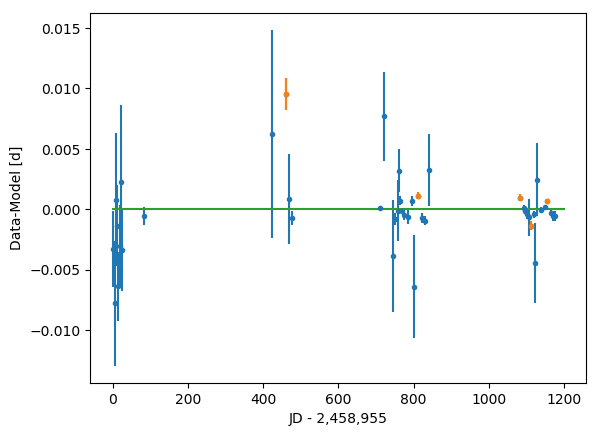

PyObject Text(24.0, 0.5, 'Data-Model [d]')

In [48]:
errorbar(data[:,3],data[:,3] .- tmod_chi,data[:,4],fmt=".")
flag = abs.((data[:,3] .- tmod_chi) ./data[:,4]) .> 3.0
errorbar(data[flag,3],data[flag,3] .- tmod_chi[flag],data[flag,4],fmt=".")

plot([0,1200],[0,0])
xlabel("JD - 2,458,955")
ylabel("Data-Model [d]")

In [50]:
pbest_chi = pbest_noprior

10-element Vector{Float64}:
  6.95981258350793e-5
  0.0001342873539158128
  3.344330395214178
  5.588309503999432
  1.0369676556674814
  4.693689489415038
  0.04337695071508257
 -0.013924524796786452
 -0.01185744485193034
  0.026566268360560107

In [51]:
println("Masses: ",pbest_chi[1].*(mstar*MSUN/MEARTH)," M_e ",pbest_chi[2].*(mstar*MSUN/MEARTH)," M_e")
println("Periods: ",pbest_chi[3]," d, ",pbest_chi[4]," d")
println("Eccentricities: ",sqrt(pbest_chi[9]^2+pbest_chi[7]^2)," ",sqrt(pbest_chi[10]^2+pbest_chi[8]^2))

Masses: 7.785282563433495 M_e 15.021453270275533 M_e
Periods: 3.344330395214178 d, 5.588309503999432 d
Eccentricities: 0.04496842060552351 0.029994316218604114


In [89]:
ic_chi.elements

3×7 Matrix{Float64}:
 1.0          0.0      0.0       0.0        0.0        1.5708  3.14159
 7.07213e-5   3.34462  1.0353    0.0344747  0.0289608  1.5708  3.14159
 0.000128126  5.58828  4.71732  -0.0192296  0.0608467  1.5708  3.14159

In [108]:
using JLD2
#@save "T1_7planet_2021_v15.jld" pbest_pp F_pp G_pp H_pp telapse_pp dchi_pp ic_pp pbest_noprior F_noprior G_noprior H_noprior telapse_noprior dchi_noprior ic_noprior
# @save "TOI2015_v07_5-3_chisquare_09182023.jld" pbest_chi F_chi G_chi H_chi telapse_chi dchi_chi ic_chi
@save "TOI2015_v13_5-3_chisquare_09182023.jld" pbest_noprior F_noprior G_noprior H_noprior telapse_noprior dchi_noprior ic_chi

In [110]:
# Check out how the values & uncertainties change with the prior:
H_chi = H_noprior
Hinv = inv(0.5*H_chi + 0.5*H_chi') #; Hinv_pp = inv(H_pp)
fac1 = [mstar*MSUN/MEARTH,mstar*MSUN/MEARTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
fac2 = [1e-6*mstar*MSUN/MEARTH,1e-6*mstar*MSUN/MEARTH,1.0,1.0,1.0,1.0,1e-3,1e-3,1e-3,1e-3]
for i=1:5*nplanet
  #println(i," ",pbest_noprior[i],"+-",sqrt(Hinv[i,i]),"; ",pbest_pp[i],"+-",sqrt(Hinv_pp[i,i]))
  println(i," ",pbest_chi[i]*fac1[i],"+-",sqrt(Hinv[i,i]*2)*fac2[i]) #,"; ",pbest_pp[i],"+-",sqrt(Hinv_pp[i,i]))
end

1 7.910925858964606+-0.44164288384623446
2 14.332261332241966+-1.2730232428905808
3 3.3446195164535464+-0.00014441824196316413
4 5.588277065507592+-0.00035900198244208484
5 1.035296209183558+-0.0013664746652617727
6 4.717322512264886+-0.03978761994442879
7 0.034474743542576965+-0.003219231218643078
8 -0.01922963971127812+-0.0033112688515906006
9 0.028960812880981502+-0.02523672148253939
10 0.06084667223326246+-0.019494422018167055


In [415]:
Hinv

10×10 Matrix{Float64}:
  427.633        364.75       -0.00268548   …  -795.761       -676.086
  364.75        2810.63        0.0181154       -284.377       -358.097
   -0.00268548     0.0181154   2.65681e-7         0.0264743      0.0202972
    0.0279909     -0.165693   -1.84663e-6        -0.108771      -0.0816653
    0.00305713     0.0320559   1.883e-7           0.00434944     0.00267148
   -1.06527      -25.9407     -0.000207941  …    -1.69435       -0.500525
 1948.47        5756.58        0.0298896       -485.917       -759.316
 1205.32         802.86       -0.00477411      -504.007       -556.624
 -795.761       -284.377       0.0264743       6843.15        5357.27
 -676.086       -358.097       0.0202972       5357.27        4212.07

In [416]:
# Convert semi-amplitude into mass:
mpsini(semi,p,mstar,ecc) = (2pi*GRAV/(p*24*3600*(1-ecc^2)))^(-1//3)*semi*100.0*(mstar*MSUN)^(2//3)

mstar = 0.336

println(mpsini(15.0,p1,mstar,0.0)/MEARTH)
println(mpsini(sqrt(coeff[3]^2+coeff[4]^2),p1,mstar,0.0)/MEARTH)

m1 = mpsini(coeff[2],p1,mstar,0.0)/(mstar*MSUN)
m2 = mpsini(sqrt(coeff[3]^2+coeff[4]^2),p2,mstar,0.0)/(mstar*MSUN)

6.202005136765667
10.839890349125094


0.0001153141353728242

In [417]:
coeff

4-element Vector{Float64}:
  6.6674505206076145
  5.485603284820093
 -9.297324611440047
  2.341986553831619

In [102]:
# Rerun the integration.
# Save the position at each step of the integration:
@time begin
intr.tmax = 4000.0;
nstep = 64000;
s = State(ic_chi);
data_sim = zeros(nstep+1,6*(nplanet+1)+1)
data_sim[1,1] = ic_chi.t0
data_sim[1,  2:3*(nplanet+1)+1] .= vec(s.x)
data_sim[1,3*(nplanet+1)+2:end] .= vec(s.v)
for i=2:nstep+1
  intr.scheme(s,intr.h);
  s.t[1] = ic_chi.t0 + i*intr.h;
  data_sim[i,1] = s.t[1];
  data_sim[i,2:3*(nplanet+1)+1] .= vec(s.x);
  data_sim[i,3*(nplanet+1)+2:end] .= vec(s.v)
end
end

  0.411910 seconds (1.94 M allocations: 106.780 MiB, 8.48% gc time, 19.90% compilation time)


In [103]:
# Compute the orbital elements at each output step:
@time begin
    t,eloft1 = compute_elements(data_sim,ic.elements[:,1],nplanet+1);
end;

  0.552091 seconds (953.66 k allocations: 88.273 MiB, 2.66% gc time, 52.58% compilation time)


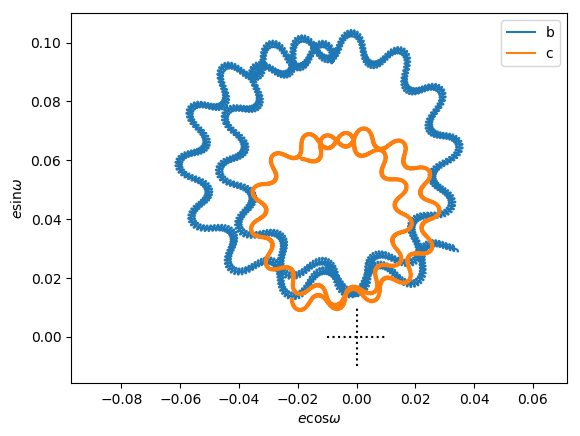

(-0.06652112490046445, 0.04098109049987109, -0.01571573970136772, 0.11003053372872207)

In [104]:
# Make a plot of the eccentricity vector evolution:
pygui(false)
pcolor = ["C0","C1","C2","C3","C4","C5","C6","C7"]
pname = ["b","c","d","e","f","g","h","i"]
for j=1:2
  ecos1 = eloft1[:,3,j].*cos.(eloft1[:,4,j])
  esin1 = eloft1[:,3,j].*sin.(eloft1[:,4,j])
  plot(ecos1,esin1,color=pcolor[j],label=pname[j])
  #ecos1_pp = eloft1_pp[:,3,j].*cos.(eloft1_pp[:,4,j])
  #esin1_pp = eloft1_pp[:,3,j].*sin.(eloft1_pp[:,4,j])
  #plot(ecos1_pp,esin1_pp,label=pname[j],color=pcolor[j])
end
plot([-0.01,0.01],[0.0,0.0],":",color="k")
plot([0.0,0.0],[-0.01,0.01],":",color="k")
legend()
ylabel(L"$e\sin{\omega}$")
xlabel(L"$e\cos{\omega}$")

axis("equal")

In [472]:
writedlm("TOI2015c_5-3_forecast.txt",ttall .+ tref .- 2450000.0)